<a href="https://colab.research.google.com/github/osu28/boilermakeIX/blob/main/geo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from google.colab import drive
from torchvision import datasets, transforms, models
import pandas as pd
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
REBUILD_DATA = True
class Compare():
  IMG_SIZE = 50
  new_york_city = "drive/MyDrive/cities/new_york_city"
  austin = "drive/MyDrive/cities/austin"
  los_angeles = "drive/MyDrive/cities/los_angeles"
  chicago = "drive/MyDrive/cities/chicago"
  houston = "drive/MyDrive/cities/houston"
  LABELS = {new_york_city: 0, austin: 1, los_angeles: 1, chicago: 1, houston: 1}
  training_data = []

  new_york_city_count = 0
  austin_count = 0  
  
  def make_training_data(self):
    
    for label in self.LABELS:
      print("Labels: " + label)

      # images = glob.glob(label)
      # print("IMG: " + str(images))

      for f in tqdm(os.listdir(label)):
        
        try:
          path = os.path.join(label, f)
          img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
          img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
          
          self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

          # if label == self.new_york_city:
          #   self.new_york_city_count += 1
          # elif label == self.austin:
          #   self.austin_count += 1
        except Exception as e:
          print(str(e))
    np.random.shuffle(self.training_data)
    np.save("training_data.npy", self.training_data)
    # print("")
    # print("New York City: ", self.new_york_city_count)
    # print("Austin: ", self.austin_count)

if REBUILD_DATA:
  compare = Compare()
  compare.make_training_data()

training_data = np.load("training_data.npy", allow_pickle=True)
print(str(training_data[0]))

Labels: drive/MyDrive/cities/new_york_city


100%|██████████| 100/100 [00:02<00:00, 44.96it/s]


Labels: drive/MyDrive/cities/austin


100%|██████████| 100/100 [00:02<00:00, 47.50it/s]


Labels: drive/MyDrive/cities/los_angeles


100%|██████████| 100/100 [00:02<00:00, 46.66it/s]


Labels: drive/MyDrive/cities/chicago


100%|██████████| 100/100 [00:02<00:00, 47.31it/s]


Labels: drive/MyDrive/cities/houston


100%|██████████| 100/100 [00:02<00:00, 43.42it/s]

[array([[ 91, 121,  70, ..., 103, 103, 103],
       [156, 106, 104, ..., 103, 103, 103],
       [ 59, 140, 175, ..., 103, 103, 103],
       ...,
       [ 54,  33,  32, ...,  52,  69,  76],
       [ 79,  64,  66, ...,  52,  68,  71],
       [ 52,  32,  37, ...,  57,  66,  69]], dtype=uint8)
 array([0., 1.])]



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


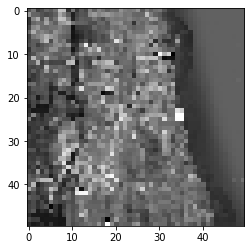

In [3]:
import matplotlib.pyplot as plt
plt.imshow(training_data[0][0], cmap="gray")
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [5]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [6]:
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """Entry point for launching an IPython kernel.


In [7]:
BATCH_SIZE = 20
EPOCHS = 10

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

100%|██████████| 23/23 [00:02<00:00,  9.74it/s]


Epoch: 0. Loss: 0.09342783689498901


100%|██████████| 23/23 [00:02<00:00, 10.08it/s]


Epoch: 1. Loss: 0.08650688827037811


100%|██████████| 23/23 [00:02<00:00, 10.68it/s]


Epoch: 2. Loss: 0.0666395053267479


100%|██████████| 23/23 [00:02<00:00, 10.72it/s]


Epoch: 3. Loss: 0.041671548038721085


100%|██████████| 23/23 [00:02<00:00, 10.54it/s]


Epoch: 4. Loss: 1.9467053789412603e-05


100%|██████████| 23/23 [00:02<00:00, 10.46it/s]


Epoch: 5. Loss: 0.0001030399143928662


100%|██████████| 23/23 [00:02<00:00, 10.54it/s]


Epoch: 6. Loss: 1.834762588259764e-05


100%|██████████| 23/23 [00:02<00:00, 10.61it/s]


Epoch: 7. Loss: 1.791904287529178e-05


100%|██████████| 23/23 [00:02<00:00, 10.69it/s]


Epoch: 8. Loss: 7.081338117131963e-05


100%|██████████| 23/23 [00:02<00:00, 10.80it/s]

Epoch: 9. Loss: 2.0489962480496615e-05


In [8]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)
        # print(predicted_class)
        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 50/50 [00:00<00:00, 393.71it/s]

Accuracy:  1.0


In [9]:
torch.save(net, 'geo_model.pth')

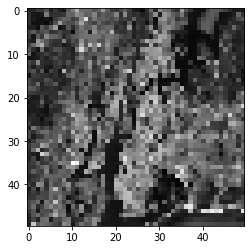

In [10]:
# inference with uploaded picture

model = torch.load('geo_model.pth')

IMG_SIZE = 50
test_pic = "drive/MyDrive/cities/nyc_test.png"
img = cv2.imread(test_pic, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))


plt.imshow(np.array(img), cmap="gray")
plt.show()

In [11]:
testing = []
testing.append([np.array(img), np.eye(2)[0]])

X = torch.Tensor([i[1] for i in testing])
X = X/255.0
y = torch.Tensor([i[1] for i in testing])


test_X = X
test_y = y

# print(test_X)
real_class = torch.argmax(test_y[0])
# net_out = net(test_X[0])[0]  # returns a list, 
# predicted_class = torch.argmax(net_out)
print(real_class)

tensor(0)


In [12]:
from torch.autograd import Variable

# test_transforms = transforms.Compose([transforms.Resize(50),
#                                       transforms.ToTensor(),
#                                      ])

# def predict_image(image):
#     # image_tensor = test_transforms(image).float()
#     # image_tensor = image_tensor.unsqueeze_(0)
#     input = Variable(torch.from_numpy(image))
#     print(input)
#     output = model(input)
#     index = output.data.cpu().numpy().argmax()
#     return index

In [13]:
#  from PIL import Image

# transform = transforms.ToTensor()
# img = Image.open(test_pic)
# input = transform(img)
# input = input.unsqueeze_(0)
# model.eval()
# output = model(input)